# Example: Deep structural causal model counterfactuals

In [1]:
%reload_ext tensorboard
%reload_ext autoreload
%autoreload 2
%pdb off

from typing import Dict, List, Optional, Tuple, Union, TypeVar

import os
import gzip
import struct

import torch
import skimage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl

import pyro
import pyro.infer
import pyro.distributions as dist
import pyro.distributions.transforms as Transforms
from pyro.nn import PyroParam, PyroSample, PyroModule

import causal_pyro
from causal_pyro.query.do_messenger import do
from causal_pyro.counterfactual.handlers import Factual, MultiWorldCounterfactual
from causal_pyro.reparam.soft_conditioning import TransformInferReparam

pyro.clear_param_store()
pyro.settings.set(module_local_params=True)
pyro.set_rng_seed(1234)

Automatic pdb calling has been turned OFF


## Background: Normalizing flows and counterfactuals

Much of the causal inference literature has focused on relatively simple
causal models with low dimensional data. In order to perform
counterfactual reasoning in more complex domains with high dimensional
data, Palowski et al. [@pawlowski2020deep] introduced *deep structural
causal models* (Deep SCMs): SCMs with neural networks as the functional
mechanisms between variables.

Specifically, the neural networks are
*normalizing flows*. A normalizing flow transforms a base probability
distribution (often a simple distribution, such as a multivariate
Gaussian) through a sequence of invertible transformations into a more
complex distribution (such as a distribution over images). When used
within a Deep SCM, the flow's base distribution is an exogenous noise
variable, and its output is an endogenous variable.

A salient property
of normalizing flows is that computing the likelihood of data can be
done both exactly and efficiently, and hence training a flow to model a
data distribution through maximum likelihood is straightforward. In
addition, the inverse of a normalizing flow can also typically be
efficiently computed, which renders the abduction step of a
counterfactual---inferring the posterior over exogenous variables given
evidence---trivial.

## Example: Morpho-MNIST

We consider a synthetic dataset based on MNIST, where the image of each digit ($X$) depends on stroke thickness ($T$) and brightness ($I$) of the image and the thickness depends on brightness as well.

We assume we know full causal structure (i.e., there are no unconfounded variables).

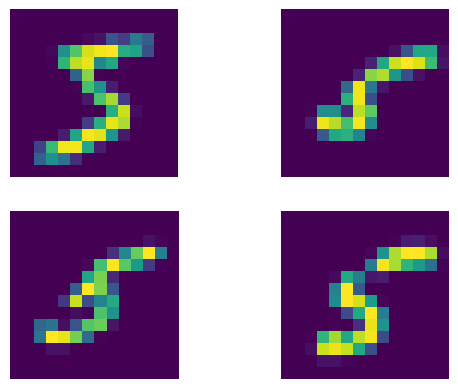

In [2]:
def load_idx(path: str) -> np.ndarray:
    with (gzip.open(path, 'rb') if path.endswith('.gz') else open(path, 'rb')) as f:
        idx_dtype, ndim = struct.unpack('BBBB', f.read(4))[2:]
        shape = struct.unpack('>' + 'I' * ndim, f.read(4 * ndim))
        buffer_length = int(np.prod(shape))
        return np.frombuffer(f.read(buffer_length), dtype=np.uint8).reshape(shape).astype(np.float32)
    
DATA_PATH = os.path.join(os.getcwd(), "../datasets/morphomnist/")
DIGIT = 5

raw_images = load_idx(os.path.join(DATA_PATH, "train-images-idx3-ubyte.gz"))
raw_images = skimage.measure.block_reduce(raw_images, block_size=(1, 2, 2))

raw_labels = load_idx(os.path.join(DATA_PATH, "train-labels-idx1-ubyte.gz"))
raw_metrics = pd.read_csv(os.path.join(DATA_PATH, "train-morpho.csv"), index_col= 'index')
raw_thickness = np.array(raw_metrics["thickness"])[..., None]
raw_intensity = np.array(raw_metrics["intensity"])[..., None]

digit_indices = (raw_labels == DIGIT) if DIGIT is not None else (raw_labels == raw_labels)

labels = torch.tensor(raw_labels[digit_indices]).to(torch.long).requires_grad_(False).detach()
images = torch.tensor(raw_images[np.broadcast_to(digit_indices[..., None, None], raw_images.shape)].reshape(-1, 1, *raw_images.shape[-2:])).to(torch.float32).requires_grad_(False).detach()
thickness = torch.tensor(raw_thickness[digit_indices]).to(torch.float32).requires_grad_(False).detach()
intensity = torch.tensor(raw_intensity[digit_indices]).to(torch.float32).requires_grad_(False).detach()

fig = plt.figure()
for i in range(4):
    fig.add_subplot(2, 2, i + 1)
    plt.imshow(images[i, 0])
    plt.axis('off')

## Model: deep structural causal model

The following code models morphological transformations of MNIST,
defining a causal generative model over digits that contains endogenous
variables to control the width $t$ and intensity $i$ of the stroke:

In [3]:
class ConstantParamTransformModule(dist.torch_transform.TransformModule):
    def __init__(self, transform: Transforms.Transform):
        super().__init__()
        self._transform = transform
        self.domain = transform.domain
        self.codomain = transform.codomain
        self.bijective = transform.bijective
        
    @property
    def sign(self):
        return self._transform.sign
        
    def _call(self, x):
        return self._transform(x)
    
    def _inverse(self, y):
        return self._transform.inv(y)
    
    def log_abs_det_jacobian(self, x, y):
        return self._transform.log_abs_det_jacobian(x, y)
    
    def with_cache(self, *args):
        return self._transform.with_cache(*args)


class ComposeTransformModule(Transforms.ComposeTransformModule):
    def __init__(self, transforms: List[Transforms.Transform]):
        super().__init__([
            ConstantParamTransformModule(t) if not isinstance(t, torch.nn.Module) else t for t in transforms
        ])
        

class InverseConditionalTransformModule(dist.conditional.ConditionalTransformModule):
    
    def __init__(self, transform: dist.conditional.ConditionalTransform):
        super().__init__()
        self._transform = transform
    
    @property
    def inv(self) -> dist.conditional.ConditionalTransform:
        return self._transform
    
    def condition(self, context: torch.Tensor):
        return self._transform.condition(context).inv


class ConditionalComposeTransformModule(dist.conditional.ConditionalTransformModule):
    def __init__(self, transforms: List):
        self.transforms = [
            dist.conditional.ConstantConditionalTransform(t)
            if not isinstance(t, dist.conditional.ConditionalTransform)
            else t
            for t in transforms
        ]
        super().__init__()
        # for parameter storage...  TODO is this necessary?
        self._transforms_module = torch.nn.ModuleList([t for t in transforms if isinstance(t, torch.nn.Module)])
        
    @property
    def inv(self):
        return InverseConditionalTransformModule(self)

    def condition(self, context: torch.Tensor):
        return ComposeTransformModule([t.condition(context) for t in self.transforms]).with_cache(1)

In [4]:
class ThicknessTransform(ComposeTransformModule):
    def __init__(self, thickness_size: int, weight: float, bias: float):
        self.thickness_size = thickness_size
        super().__init__([
            Transforms.Spline(thickness_size, bound=1.),
            Transforms.AffineTransform(loc=bias, scale=weight),
            Transforms.biject_to(dist.constraints.positive),
        ])

class IntensityTransform(ConditionalComposeTransformModule):
    def __init__(
        self,
        intensity_size: int,
        thickness_size: int,
        hidden_dims: List[int],
        weight: float,
        bias: float,
        *,
        count_bins: int = 8,
        nonlinearity=torch.nn.ReLU(),
    ):
        self.intensity_size = intensity_size
        self.thickness_size = thickness_size
        self.hidden_dims = hidden_dims
        
        intensity_nn = pyro.nn.DenseNN(
            thickness_size,
            hidden_dims,
            param_dims=[
                intensity_size * count_bins,
                intensity_size * count_bins,
                intensity_size * (count_bins - 1),
                intensity_size * count_bins,
            ],
            nonlinearity=nonlinearity,
        )
        super().__init__([
            Transforms.ConditionalSpline(intensity_nn, intensity_size, count_bins),
            Transforms.AffineTransform(loc=bias, scale=weight),
            Transforms.SoftplusTransform(),
        ])

The transformation for the images is somewhat involved. Much of the neural network architecture is taken from [this PyTorch tutorial] on normalizing flows, which readers are encouraged to peruse for further background on normalizing flows in general and this architecture in particular.

In [5]:
class ConcatELU(torch.nn.Module):
    """
    Activation function that applies ELU in both direction (inverted and plain).
    Allows non-linearity while providing strong gradients for any input (important for final convolution)
    """
    def forward(self, x):
        return torch.cat([torch.nn.functional.elu(x), torch.nn.functional.elu(-x)], dim=-3)


class LayerNormChannels(torch.nn.Module):

    def __init__(self, c_in: int, eps: float = 1e-5):
        """
        This module applies layer norm across channels in an image.
        Inputs:
            c_in - Number of channels of the input
            eps - Small constant to stabilize std
        """
        super().__init__()
        self.gamma = torch.nn.Parameter(torch.ones(1, c_in, 1, 1))
        self.beta = torch.nn.Parameter(torch.zeros(1, c_in, 1, 1))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=-3, keepdim=True)
        var = x.var(dim=-3, unbiased=False, keepdim=True)
        y = (x - mean) / torch.sqrt(var + self.eps)
        y = y * self.gamma + self.beta
        return y


class GatedConv(torch.nn.Module):

    def __init__(self, c_in: int, c_hidden: int):
        """
        This module applies a two-layer convolutional ResNet block with input gate
        Inputs:
            c_in - Number of channels of the input
            c_hidden - Number of hidden dimensions we want to model (usually similar to c_in)
        """
        super().__init__()
        self.net = torch.nn.Sequential(
            ConcatELU(),
            torch.nn.Conv2d(2*c_in, c_hidden, kernel_size=3, padding=1),
            ConcatELU(),
            torch.nn.Conv2d(2*c_hidden, 2*c_in, kernel_size=1)
        )

    def forward(self, x):
        out = self.net(x)
        val, gate = out.chunk(2, dim=-3)
        return x + val * torch.sigmoid(gate)


class GatedConvNet(torch.nn.Module):

    def __init__(self, c_in: int, c_hidden: int, num_layers: int, eps: float = 1e-5):
        """
        Module that summarizes the previous blocks to a full convolutional neural network.
        Inputs:
            c_in - Number of input channels
            c_hidden - Number of hidden dimensions to use within the network
            c_out - Number of output channels.
            num_layers - Number of gated ResNet blocks to apply
        """
        super().__init__()
        c_out = 2 * c_in
        layers = []
        layers += [torch.nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)]
        for layer_index in range(num_layers):
            layers += [
                GatedConv(c_hidden, c_hidden),
                LayerNormChannels(c_hidden, eps=eps)
            ]
        layers += [
            ConcatELU(),
            torch.nn.Conv2d(2*c_hidden, c_out, kernel_size=3, padding=1)
        ]
        self.nn = torch.nn.Sequential(*layers)

        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()

    def forward(self, x):
        return self.nn(x)


class MaskedAffineCoupling(dist.torch_transform.TransformModule):
    bijective = True
    domain = dist.constraints.independent(dist.constraints.real, 3)
    codomain = dist.constraints.independent(dist.constraints.real, 3)

    def __init__(self, network: torch.nn.Module, mask: torch.Tensor, c_in: int, h: int, w: int):
        """
        Coupling layer inside a normalizing flow.
        Inputs:
            network - A PyTorch nn.Module constituting the deep neural network for mu and sigma.
                      Output shape should be twice the channel size as the input.
            mask - Binary mask (0 or 1) where 0 denotes that the element should be transformed,
                   while 1 means the latent will be used as input to the NN.
            c_in - Number of input channels
        """
        self.c_in = c_in
        self.h = h
        self.w = w
        super().__init__()
        self.network = network
        self.scaling_factor = torch.nn.Parameter(torch.zeros(c_in, device=mask.device))
        self.register_buffer('mask', mask)
        
    def with_cache(self, *args):
        return self
        
    def _net(self, x):
        s, t = self.network(x * self.mask).chunk(2, dim=-3)

        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac

        # Mask outputs (only transform parts where self.mask == 0)
        return s * (1 - self.mask), t * (1 - self.mask)
        
    def log_abs_det_jacobian(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        s, _ = self._net(x)
        return s.sum(dim=[-1,-2,-3])
    
    def _inverse(self, y: torch.Tensor) -> torch.Tensor:
        s, t = self._net(y)
        return (y * torch.exp(-s)) - t
    
    def _call(self, x: torch.Tensor) -> torch.Tensor:
        s, t = self._net(x)
        return (x + t) * torch.exp(s)


class ImageTransform(ConditionalComposeTransformModule):
    def __init__(
        self,
        im_size: int,
        input_channels: int,
        thickness_size: int,
        intensity_size: int,
        num_blocks: int,
        layers_per_block: int,
        hidden_channels: int,
        *,
        num_cond_blocks: int = 1,
        alpha: float = 1e-5,
        bn_momentum: float = 0.05,
        ln_momentum: float = 1e-5,
        nonlinearity = torch.nn.ReLU(),
    ):
        self.im_size = im_size
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.num_blocks = num_blocks
        self.layers_per_block = layers_per_block
        
        self.num_cond_blocks = num_cond_blocks
        
        self.flat_input_size = input_channels * im_size * im_size
        
        layers = []

        # dequantization
        layers += [
            Transforms.IndependentTransform(
                Transforms.ComposeTransform([
                    Transforms.AffineTransform(0., 1. / 256),
                    Transforms.AffineTransform(alpha, (1 - alpha)),
                    Transforms.SigmoidTransform().inv,
            ]), 3)
        ]
        
        # image flow with convolutional blocks
        for i in range(num_blocks):
            layers += [
                MaskedAffineCoupling(
                    GatedConvNet(input_channels, hidden_channels, layers_per_block, eps=ln_momentum),
                    self.create_checkerboard_mask(im_size, im_size, invert=(i%2==1)),
                    input_channels,
                    im_size,
                    im_size,
                ),
            ]
            
        # conditioning on context
        layers += [Transforms.ReshapeTransform((input_channels, im_size, im_size), (self.flat_input_size,))]
        for i in range(self.num_cond_blocks):
            layers += [
                Transforms.ConditionalAffineAutoregressive(
                    pyro.nn.ConditionalAutoRegressiveNN(
                        self.flat_input_size,
                        thickness_size + intensity_size,
                        [2 * self.flat_input_size] * 2,
                        nonlinearity=nonlinearity,
                        skip_connections=True,
                    ),
                ),
            ]  
        layers += [Transforms.ReshapeTransform((self.flat_input_size,), (input_channels, im_size, im_size))]
        
        super().__init__(layers)
            
    @staticmethod
    def create_checkerboard_mask(h: int, w: int, invert=False):
        x, y = torch.arange(h, dtype=torch.int32), torch.arange(w, dtype=torch.int32)
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        mask = torch.fmod(xx + yy, 2).to(torch.float32).view(1, 1, h, w)
        return mask if not invert else (1. - mask)

With all of these components defined, we can finally define the high-level causal model we'll be using:

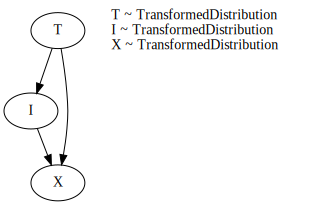

In [6]:
class DeepSCM(PyroModule):
    
    thickness_support = dist.constraints.positive
    intensity_support = dist.constraints.positive

    def __init__(
        self,
        thickness_transform: ThicknessTransform,
        intensity_transform: IntensityTransform,
        image_transform: ImageTransform,
        *,
        include_thickness: bool = True,
        include_intensity: bool = True,
        include_image: bool = True,
    ):
        super().__init__()
        # mechanisms
        self.thickness_transform = thickness_transform
        self.intensity_transform = intensity_transform
        self.image_transform = image_transform.inv  # generative direction is inverse
        
        # base dist buffers
        self.register_buffer("base_loc", torch.tensor(0.))
        self.register_buffer("base_scale", torch.tensor(1.))

        # tensor sizes
        self.thickness_size = self.thickness_transform.thickness_size
        self.intensity_size = self.intensity_transform.intensity_size
        self.im_size = self.image_transform._transform.im_size
        self.im_input_channels = self.image_transform._transform.input_channels
        
        # prior masks
        self.include_thickness = include_thickness
        self.include_intensity = include_intensity
        self.include_image = include_image

    def StandardNormal(self, *event_shape: int) -> Union[dist.Independent, dist.Normal]:
        return dist.Normal(self.base_loc, self.base_scale).expand(event_shape).to_event(len(event_shape))
    
    @staticmethod
    def cond_dist(
        transform: Union[Transforms.Transform, dist.conditional.ConditionalTransform],
        U_dist: dist.Distribution,
        *contexts: torch.Tensor
    ) -> dist.Distribution:
        if contexts:
            batch_shape = torch.broadcast_shapes(*(c.shape[:-1] for c in contexts))
            U_dist = U_dist.expand(torch.broadcast_shapes(batch_shape, U_dist.batch_shape))
            context = torch.cat([c.expand(batch_shape + (-1,)) for c in contexts], dim=-1)
            transform = transform.condition(context)
        return dist.TransformedDistribution(U_dist, transform)

    def forward(self):
        # Thickness:
        UT_dist = self.StandardNormal(self.thickness_size)
        T_dist = self.cond_dist(self.thickness_transform, UT_dist)
        T = pyro.sample("T", T_dist.mask(self.include_thickness))
        T_unconstrained = Transforms.biject_to(self.thickness_support).inv(T)

        # Intensity:
        UI_dist = self.StandardNormal(self.intensity_size)
        I_dist = self.cond_dist(self.intensity_transform, UI_dist, T_unconstrained)
        I = pyro.sample("I", I_dist.mask(self.include_intensity))
        I_unconstrained = Transforms.biject_to(self.intensity_support).inv(I)

        # Image:
        UX_dist = self.StandardNormal(self.im_input_channels, self.im_size, self.im_size)
        X_dist = self.cond_dist(self.image_transform, UX_dist, T_unconstrained, I_unconstrained)
        X = pyro.sample("X", X_dist.mask(self.include_image))

        return X

thickness_transform = ThicknessTransform(
    thickness.shape[-1],
    weight=thickness.log().mean().detach().item(),
    bias=thickness.log().std().detach().item(),
)

intensity_transform = IntensityTransform(
    intensity.shape[-1],
    thickness.shape[-1],
    hidden_dims=[16],
    weight=intensity.min().detach().item(),
    bias=(intensity.max() - intensity.min()).detach().item(),
    nonlinearity=torch.nn.ELU(),
    count_bins=4,
)

image_transform = ImageTransform(
    images.shape[-1],
    1,
    thickness.shape[-1],
    intensity.shape[-1],
    num_blocks=8,
    layers_per_block=3,
    hidden_channels=16,
    nonlinearity=torch.nn.ELU(),
)

model = DeepSCM(thickness_transform, intensity_transform, image_transform, include_thickness=True, include_intensity=True, include_image=True)
pyro.render_model(model, render_distributions=True)

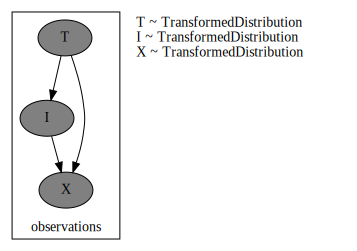

In [7]:
class ConditionedDeepSCM(PyroModule):
    def __init__(self, model: DeepSCM):
        super().__init__()
        self.model = model
        
    def forward(self, t_obs, i_obs, x_obs):
        with pyro.condition(data={"X": x_obs, "T": t_obs, "I": i_obs}), \
                pyro.poutine.scale(scale=1 / x_obs.shape[0]), \
                pyro.plate("observations", size=x_obs.shape[0], dim=-1):
            return self.model()

conditioned_model = ConditionedDeepSCM(model)
pyro.render_model(conditioned_model, model_args=(thickness[:2], intensity[:2], images[:2]), render_distributions=True)

In [8]:
adam_params = {"lr": 1e-3}
batch_size = 128
num_epochs = 100

class LightningSVI(pl.LightningModule):
    def __init__(self, model: ConditionedDeepSCM, guide: PyroModule, elbo: pyro.infer.ELBO, optim_params: dict):
        super().__init__()
        self.model = model
        self.guide = guide
        self.elbo = elbo(self.model, self.guide)
        self._optim_params = optim_params

    def training_step(self, batch, batch_idx):
        t_obs, i_obs, x_obs = batch
        x_obs = x_obs + torch.rand_like(x_obs)
        loss = self.elbo(t_obs, i_obs, x_obs)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
#         optimizer = torch.optim.Adam([
#             dict(params=self.model.model.thickness_transform.parameters()),
#             dict(params=self.model.model.intensity_transform.parameters()),
#             dict(params=self.guide.parameters()),
#             dict(params=self.model.model.image_transform.parameters(), lr=self._optim_params["lr"] / self.model.model.im_size ** 2)
#         ], **self._optim_params)
        optimizer = torch.optim.Adam(self.elbo.parameters(), **self._optim_params)
        return optimizer
        
guide = pyro.infer.autoguide.AutoDelta(conditioned_model)
elbo = pyro.infer.Trace_ELBO()
lightning_svi = LightningSVI(conditioned_model, guide, elbo, adam_params)

dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(thickness, intensity, images),
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
)

trainer = pl.Trainer(
    max_epochs=num_epochs,
    gradient_clip_val=1.0,
    accelerator="gpu",
    default_root_dir=os.path.join("./lightning_logs/deepscm_ckpt", "deepscm_joint"),
    callbacks=[
        pl.callbacks.ModelCheckpoint(save_weights_only=True, mode="min", monitor="train_loss"),
    ],
)
trainer.fit(model=lightning_svi, train_dataloaders=dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params
---------------------------------------------
0 | model | ConditionedDeepSCM | 607 K 
1 | guide | AutoDelta          | 0     
2 | elbo  | ELBOModule         | 607 K 
---------------------------------------------
607 K     Trainable params
0         Non-trainable params
607 K     Total params
2.428     Total estimated model params size (MB)
/home/eli/development/causal_pyro/.env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


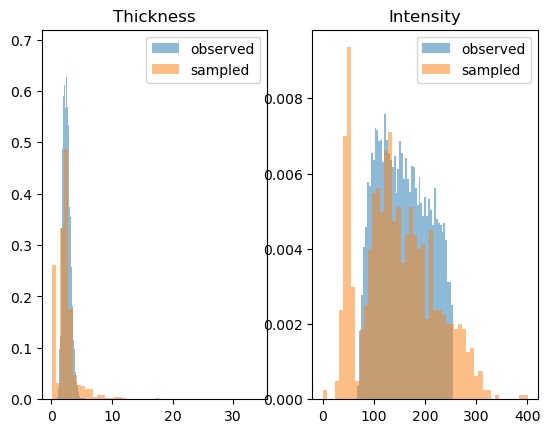

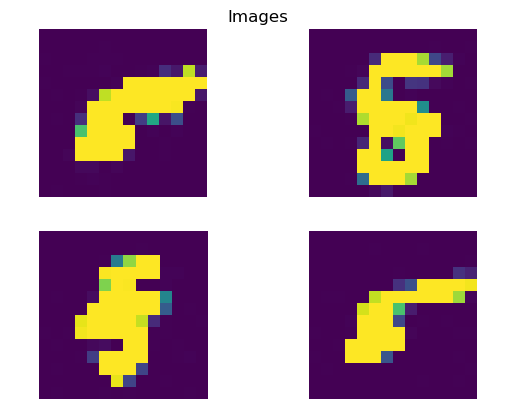

In [9]:
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1000, parallel=True).to(device=torch.device("cpu"))
samples = predictive()

fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.hist(thickness[..., 0], bins=50, alpha=0.5, density=True, label="observed")
plt.hist(samples["T"][..., 0], bins=50, alpha=0.5, density=True, label="sampled")
plt.title("Thickness")
plt.legend()

fig.add_subplot(1, 2, 2)
plt.hist(intensity[..., 0], bins=50, alpha=0.5, density=True, label="observed")
plt.hist(samples["I"][..., 0], bins=50, alpha=0.5, density=True, label="sampled")
plt.title("Intensity")
plt.legend()

fig = plt.figure()
plt.title("Images")
plt.axis("off")
for i in range(2 * 2):
    fig.add_subplot(2, 2, i + 1)
    plt.imshow(samples["X"][i].squeeze())
    plt.axis("off")

## Query: counterfactual data generation

Next we ask a *counterfactual* question: given an observed digit $X$, what
would the digit have been had $t$ been $t + 1$?

To compute this quantity we would normally:
   1. invert the model to find latent exogenous noise $u$
   2. construct an intervened model
   3. re-simulate the forward model on the $u$ [@pearl2011algorithmization].  

However, we can equivalently
represent this process with inference in a single, expanded
probabilistic program containing two copies of every deterministic
statement (a so-called \"twin network\" representation of
counterfactuals, first described in Chapter 7 of [@pearl] and extended
to the PPL setting in [@tavares_2020])

In [ ]:
class CounterfactualDeepSCM(PyroModule):
    def __init__(self, model: DeepSCM):
        super().__init__()
        self.model = model
        
    def forward(self, x_obs: torch.Tensor, i_act: torch.Tensor):
        with MultiWorldCounterfactual(dim=-2), \
                plate("observations", size=x_obs.shape[0], dim=-1), \
                do(actions={"I": i_act}), \
                condition(data={"X": x_obs}):
            return model()

cf_model = CounterfactualDeepSCM(model)
pyro.render_model(cf_model, model_args=(images[:1], intensity[:1]))

Like all counterfactuals, this estimand is not identified in general
without further assumptions: learning parameters $\theta$ that match
observed data does not guarantee that the counterfactual distribution
will match that of the true causal model. 

However, as discussed in the
original paper [@pawlowski2020deep] in the context of modeling MRI
images, there are a number of valid practical reasons one might wish to
compute it anyway, such as explanation or expert evaluation.